In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import sys
import glob
from os import listdir
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

In [2]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.models import model_from_json
from keras.optimizers import Adam

Using Theano backend.


In [3]:
#PianoRoll
sys.path.append(os.getcwd()+"/../../PianoRoll/")
sys.path.append(os.getcwd()+"/../../")
from PianoRoll import PianoRoll

In [4]:
#RNN Config
num_epochs = 3
batch_size = 128
num_layers = 1
loss_function = 'categorical_crossentropy'
optimizer = 'adam'
activ_func = "sigmoid"
validation_split = 0.05
note_threshold = 0.1
res_factor = 12
le_rate = 3e-4

#Composer paths
chord_dir = os.getcwd() + "/../../data/testData/chords/"
composition_dir = os.getcwd() + "/compositions/"

#Checkpoint paths
model_dir = os.getcwd() + "/checkpoints/model/"
weights_dir = os.getcwd() + "/checkpoints/weights/"
train_chord_path = os.getcwd() + "/../../data/trainData/chords/"
train_melody_path = os.getcwd() + "/../../data/trainData/melody/"
test_chord_path = os.getcwd() + "/../../data/testData/chords/"

#Results - Plots file
results_dir = os.getcwd() + "/results/"

#Other constants
MIDI_FILE_EXTENSION = "mid"
NOTE_ON = "note_on"
NOTE_OFF = "note_off"
MAX_NOTE = "max_note"
MIN_NOTE = "min_note"
TICKS = "ticks"
MIN_NOTE_INITIALIZER = 10000
MAX_NOTE_INITIALIZER = 0
MAX_TICK_INITIALIZER = 0
MELODY_LOWEST_NOTE = 60

# Dataset Creation Tests

In [5]:
chord_roll = PianoRoll(train_chord_path, res_factor=res_factor)
melody_roll = PianoRoll(train_melody_path, res_factor=res_factor)
chord_roll_test = PianoRoll(test_chord_path, res_factor=res_factor)
print(chord_roll.ticks, chord_roll.max_note, chord_roll.min_note)
print(melody_roll.ticks, melody_roll.max_note, melody_roll.min_note)

(256, 59, 48)
(256, 83, 60)


In [6]:
#Test the Chord piano roll
x = chord_roll.generate_piano_roll_func()
y = chord_roll.generate_piano_roll()
print(x.shape)
print(y.shape)
np.testing.assert_equal(x, y)

(68, 256, 12)
(68, 256, 12)


In [7]:
# Test the melody piano roll
x = melody_roll.generate_piano_roll_func()
y = melody_roll.generate_piano_roll()
print(x.shape)
print(y.shape)
np.testing.assert_equal(x, y)

(68, 256, 24)
(68, 256, 24)


In [8]:
#Test Train and Test samples
chord_data = chord_roll.generate_piano_roll()
chord_double = PianoRoll.doubleRoll(chord_data)
mel_data = melody_roll.generate_piano_roll()
mel_double = PianoRoll.doubleRoll(mel_data)
# chord_data_test = chord_roll_test.generate_piano_roll()
# chord_double_test = PianoRoll.doubleRoll(chord_data_test)

ip_data, tar_data = PianoRoll.createNetInputs(chord_double, mel_double, seq_length=256)
y_ip, y_tar = PianoRoll.generate_samples(chord_data, mel_data, seq_length=chord_roll.ticks)


np.testing.assert_equal(ip_data, y_ip)
np.testing.assert_equal(tar_data, y_tar)
X_train = ip_data.astype(np.int32)
Y_train = tar_data.astype(np.int32)

In [9]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.stats = {
            "loss_history": [],
            "train_acc_history": [],
            "val_acc_history": []
        }

    def on_batch_end(self, batch, logs={}):
        self.stats["loss_history"].append(logs.get("loss"))
    
    def on_epoch_end(self, epoch, logs={}):
        self.stats["train_acc_history"].append(logs.get("acc"))
        self.stats["val_acc_history"].append(logs.get("val_acc"))

In [10]:
def visualize(stats, title):
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.savefig(results_dir + title)
    plt.show()

# Build LSTM Network

In [11]:
D = X_train.shape[2] #Number of input dimensions
C = Y_train.shape[1] #Number of classes
model = Sequential()
if num_layers <= 1:
    model.add(LSTM(input_dim = D, output_dim=C, activation=activ_func, return_sequences=False))
else:
    layer_dims = int(input("Enter the number of units in hidden layer#{}\t".format(1)))
    model.add(LSTM(input_dim = D, output_dim=layer_dims, activation=activ_func, return_sequences=True))
    for layer_id in range(2, num_layers):
        layer_dims = int(input("Enter the number of units in the hidden layer#{}\t".format(layer_id)))
        model.add(LSTM(output_dim=layer_dims, activation=activ_func, return_sequences=True))
    model.add(LSTM(output_dim=C, activation=activ_func, return_sequences=False))
print(model.summary())
# print(model.get_config())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 24)            3552        lstm_input_1[0][0]               
Total params: 3552
____________________________________________________________________________________________________
None


In [12]:
if optimizer == "adam":
    opt_func = Adam(lr=le_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=loss_function, metrics=["accuracy"], optimizer=optimizer)

In [13]:
history = Metrics()
model.fit(X_train, Y_train, 
          batch_size=batch_size, 
          nb_epoch=num_epochs, 
          callbacks=[history], 
          validation_split=validation_split)

Train on 16537 samples, validate on 871 samples
Epoch 1/3
16537/16537 [==============================] - 32s - loss: 1.3535 - acc: 0.0749 - val_loss: 1.3731 - val_acc: 0.0230
Epoch 2/3
16537/16537 [==============================] - 29s - loss: 1.2365 - acc: 0.0884 - val_loss: 1.3033 - val_acc: 0.0241
Epoch 3/3
16537/16537 [==============================] - 26s - loss: 1.1896 - acc: 0.0914 - val_loss: 1.2644 - val_acc: 0.0379


In [14]:
weights_file = "{}layer_{}epochs_{}".format(num_layers, num_epochs, time.strftime("%Y%m%d_%H_%M.h5"))
model.save_weights(weights_dir + weights_file)
model_file = "{}layer_{}epochs_{}".format(num_layers, num_epochs, time.strftime("%Y%m%d_%H_%M.json"))
with open(model_dir + model_file, "w") as model_file_writer:
    model_file_writer.write(model.to_json())

# Visualize the Stats

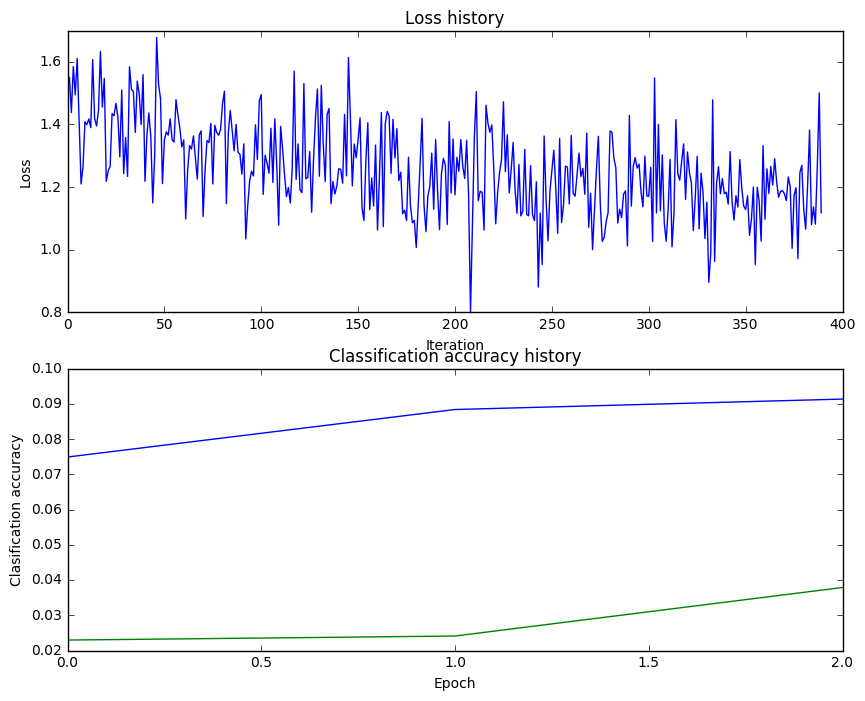

In [15]:
results_file = "lstm_{}layer_{}epochs_{}".format(num_layers, num_epochs, time.strftime("%Y%m%d_%H_%M.jpg"))
visualize(history.stats, results_file)

# Compose Music

In [16]:
chord_files = glob.glob("%s*.mid" %(chord_dir))
composition_files = []
for i in range(len(chord_files)):
    composition_files.append('%d' %(i+1))
print(chord_files, composition_files)

(['/Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/../../data/testData/chords/1_testchord.mid', '/Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/../../data/testData/chords/2_testchord.mid', '/Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/../../data/testData/chords/3_testchord.mid', '/Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/../../data/testData/chords/4_testchord.mid', '/Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/../../data/testData/chords/5_testchord.mid', '/Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/../../data/testData/chords/6_testchord.mid', '/Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/../../d

In [17]:
chord_test_roll = PianoRoll(chord_dir, res_factor=res_factor)
print("# of Ticks:{}\tMax_Note:{}\tMin_Note:{}".format(chord_test_roll.ticks,
                                                  chord_test_roll.max_note,
                                                  chord_test_roll.min_note))

# of Ticks:256	Max_Note:59	Min_Note:48


In [18]:
chord_test_data = chord_test_roll.generate_piano_roll_func()
X_test = PianoRoll.generate_test_samples(chord_test_data, chord_test_roll.ticks)

In [19]:
#Load Model
model_files = listdir(model_dir)
print("Choose a file for the model:")
print("---------------------------------------")
for i, file in enumerate(model_files):
    print(str(i) + " : " + file)
print("---------------------------------------")
file_index = input("Enter the index of the file model that you want:\t")
model_path = model_dir + model_files[file_index]
print("Loading model from {}".format(model_path))
model = model_from_json(open(model_path).read())

Choose a file for the model:
---------------------------------------
0 : 1layer_3epochs_20161130_12_41.json
1 : 1layer_50epochs_20161130_12_19.json
---------------------------------------
Enter the index of the file model that you want:	1
Loading model from /Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/checkpoints/model/1layer_50epochs_20161130_12_19.json


In [20]:
#Load Weights
weights_files = listdir(weights_dir)
print("Choose a file for the weights:")
print("---------------------------------------")
for i, file in enumerate(weights_files):
    print(str(i) + " : " + file)
print("---------------------------------------")
file_index = input("Enter the file index of the weights that you want")
weights_path = weights_dir + weights_files[file_index]
print("Loading weights from ", weights_path)
model.load_weights(weights_path)

Choose a file for the weights:
---------------------------------------
0 : 1layer_3epochs_20161130_12_41.h5
1 : 1layer_50epochs_20161130_12_19.h5
---------------------------------------
Enter the file index of the weights that you want1
('Loading weights from ', '/Users/arulselvanmadhavan/cs6140-machine-learning/Keras_projects/LSTM-RNN-Melody-Composer/models/lstm/checkpoints/weights/1layer_50epochs_20161130_12_19.h5')


In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
for i, song in enumerate(X_test):
    net_output = model.predict(song)
    net_roll = PianoRoll.NetOutToPianoRoll(net_output, threshold=note_threshold)
    PianoRoll.createMidiFromPianoRoll(net_roll, MELODY_LOWEST_NOTE, composition_dir,
                                               composition_files[i], note_threshold, res_factor=res_factor)
    print("Finished composing song %d." %(i+1))

Finished composing song 1.
Finished composing song 2.
Finished composing song 3.
Finished composing song 4.
Finished composing song 5.
Finished composing song 6.
Finished composing song 7.
Finished composing song 8.


# Old Tests

In [22]:
# #Note On OFF Array Test - Shape
# from mido import MidiFile
# configs = {
#             "res_factor":train_obj.res_factor,
#             "max_note": train_obj.max_note,
#             "min_note": train_obj.min_note
#         }
# x = PianoRoll.get_note_info(train_obj.files[0], configs)
# y = PianoRoll.getNoteTimeOnOffArray(MidiFile(train_obj.files[0]), train_obj.res_factor)
# y = np.array(y)
# np.testing.assert_almost_equal(x, y)

In [23]:
# notes = x.T[0]
# for i in range(train_obj.min_note, train_obj.max_note + 1):
#     print("{}\t{}\t{}".format(i, (notes == i).sum(), ((notes == i).sum() % 2) == 0))

In [24]:
# c = [np.array(np.arange(200).reshape(2,10,10)), np.array(np.arange(200).reshape(2,10,10))]
# np.vstack(c).shape

In [25]:
# x = PianoRoll.get_note_info(train_obj.files[0], configs)
# y_temp = PianoRoll.getNoteTimeOnOffArray(MidiFile(train_obj.files[0]), train_obj.res_factor)
# y = PianoRoll.getNoteOnLengthArray(y_temp)
# np.testing.assert_almost_equal(x,y)